# 3D Code for  isothermal finite hyperelasticity

Torsion Fixed End

Basic units:
Length: mm
Mass: kg
Time:  s
Derived units:
Force: milliNewtons
Stress: kPa 

Eric Stewart and Lallit Anand   
ericstew@mit.edu and anand@mit.edu   

Converted to FEniCSx by Jorge Nin
jorgenin@mit.edu
September 2023



In [1]:
import numpy as np
import dolfinx
import petsc4py
petsc4py.init(["--log_view"])
from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split)
from datetime import datetime
from dolfinx.plot import vtk_mesh

import pyvista
pyvista.set_jupyter_backend('client')
## Define temporal parameters

In [2]:
import sys


sys.argv

['/Users/jorgenin/Documents/Python/Research/2.077/.venv/lib/python3.11/site-packages/ipykernel_launcher.py',
 '--ip=127.0.0.1',
 '--stdin=9013',
 '--control=9011',
 '--hb=9010',
 '--Session.signature_scheme="hmac-sha256"',
 '--Session.key=b"9f661141-f782-4bfd-957a-e4addd867d3a"',
 '--shell=9012',
 '--transport="tcp"',
 '--iopub=9014',
 '--f=/Users/jorgenin/Library/Jupyter/runtime/kernel-v2-37144sHMieOuFMJWy.json']

### Set level of detail for log messages (integer)
Guide: \
CRITICAL  = 50  errors that may lead to data corruption \
ERROR     = 40  things that HAVE gone wrong \
WARNING   = 30  things that MAY go wrong later \
INFO      = 20  information of general interest (includes solver info) \
PROGRESS  = 16  what's happening (broadly) \
TRACE     = 13  what's happening (in detail) \
DBG       = 10  sundry 


In [3]:
log.set_log_level(log.LogLevel.WARNING)

# Define Geometry

In [4]:
L = 25.4 # mm
R = 12.7  # Radius mm


with XDMFFile(MPI.COMM_WORLD,"meshes/cylinder.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    ct = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

with XDMFFile(MPI.COMM_WORLD, "meshes/facet_cylinder.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(domain, name="Grid")

#mvc2d = mesh.MeshValueCollection("size_t", mesh, 2)
#with XDMFFile("meshes/facet_cylinder.xdmf") as infile:
#    infile.read(mvc2d, "name_to_read")

x = ufl.SpatialCoordinate(domain)


### Visualize Gemometry

In [5]:
Wdummy = FunctionSpace(domain,("Lagrange",1))
dofs = fem.locate_dofs_topological(Wdummy,domain.topology.dim-1, ft.indices)
dofmap = Wdummy.dofmap
ft2point = domain.topology.connectivity(domain.topology.dim-1, 0)


In [6]:
top_imap = domain.topology.index_map(2)
values = np.zeros(top_imap.size_global)

values[ft.indices]=ft.values



In [7]:
np.unique(ft.values)

array([  7, 101, 102], dtype=int32)

In [28]:


plotter = pyvista.Plotter()

top = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,ft.indices[ft.values==102]) )
sides = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,ft.indices[ft.values==7]) )
bottom = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,ft.indices[ft.values==101]) )


actor = plotter.add_mesh(top, show_edges=True,color="blue")
actor2 = plotter.add_mesh(sides, show_edges=True,color="red")
actor3 = plotter.add_mesh(bottom, show_edges=True,color="green")
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:49533/index.html?ui=P_0x2a3c37810_1&reconnect=auto' style='width: …

## Functions for finding Differnent Areas

In [9]:

facet_tag = mesh.meshtags(domain, domain.topology.dim-1, ft.indices,ft.values)

ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': 4})
n = ufl.FacetNormal(domain)

## MATERIAL PARAMETERS
Arruda-Boyce Model

In [10]:
Gshear_0 = Constant(domain,PETSc.ScalarType(280.0))          # Ground state shear modulus
lambdaL  = Constant(domain,PETSc.ScalarType(5.12))             # Locking stretch
Kbulk    = Constant(domain,PETSc.ScalarType(1000.0*Gshear_0)) 

## Simulation Control

In [11]:
t         = 0.0         # start time
theta_tot = 2.5         # total rotation of end-face in radians
Ttot      = 20          # total simulation time 
numSteps  = 20 
dt        = Ttot/numSteps       # (fixed) step size


def rotationy(t):
    return uMax*np.sin(omega*t)


def rotationz(t):
    return uMax*np.sin(omega*t)


## Function Spaces

In [12]:


U2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2) # For displacement
P1 = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 1) # For  pressure
TH = ufl.MixedElement([U2, P1])     # Taylor-Hood style mixed element
ME = FunctionSpace(domain, TH)    # Total space for all DOFs

In [13]:
w = Function(ME)
u, p = split(w)
w_old         = Function(ME)
u_old,  p_old = split(w_old)

u_test, p_test = TestFunctions(ME)       
dw = TrialFunction(ME)           

## SubRoutine

In [14]:
def F_calc(u):
    Id = Identity(3) 
    F  = Id + grad(u)
    return F

def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    J = det(F)
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

# Generalized shear modulus for Arruda-Boyce model
def Gshear_AB_calc(u):
    zeta    = zeta_calc(u)
    Gshear  = Gshear_0 * zeta
    return Gshear

#---------------------------------------------
# Subroutine for calculating the Cauchy stress
#---------------------------------------------
def T_calc(u,p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    B = F*F.T
    Bdis = J**(-2/3)*B
    Gshear  = Gshear_AB_calc(u)
    T = (1/J)* Gshear * dev(Bdis) - p * Id
    return T

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u, p):
    Id = Identity(3) 
    F   = F_calc(u)
    J = det(F)
    #
    T   = T_calc(u,p)
    #
    Tmat   = J * T * inv(F.T)
    return Tmat

In [15]:
F =  F_calc(u)  
J = det(F)
lambdaBar = lambdaBar_calc(u)

# Piola stress
Tmat = Piola_calc(u, p)

## WEAK FORMS

In [16]:
dxs = dx(metadata={'quadrature_degree': 4})

In [17]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)

# The weak form for the equilibrium equation. No body force
Res_0 = inner(Tmat , grad(u_test) )*dxs

# The weak form for the pressure
fac_p = ln(J)/J
#
Res_1 = dot( (p/Kbulk + fac_p), p_test)*dxs

# Total weak form
Res = Res_0 +  Res_1 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

In [18]:
#Rotation Values
scale = 1.0
y0 = 0.0
z0 = 0.0
Time_cons = Constant(domain,PETSc.ScalarType(0))
V_1, V_1to_mE =  ME.sub(0).sub(1).collapse() #Scalar function space
V_2, V_2to_mE =  ME.sub(0).sub(2).collapse() #Scalar function space

Value1 = scale*(y0 + (x[1] - y0)*ufl.cos(theta_tot*(Time_cons/Ttot)) - (x[2] - z0)*ufl.sin(theta_tot*(Time_cons/Ttot)) - x[1])
exRot1= Expression(Value1,V_1.element.interpolation_points())
Rot1_fun = Function(V_1)
Rot1_fun.interpolate(exRot1)

Value2 = scale*(z0 + (x[1] - y0)*ufl.sin(theta_tot*(Time_cons/Ttot)) + (x[2] - z0)*ufl.cos(theta_tot*(Time_cons/Ttot)) - x[2])

exRot2= Expression(Value2,V_2.element.interpolation_points())
Rot2_fun = Function(V_2)
Rot2_fun.interpolate(exRot2)


In [19]:


ZeroValue = Constant(domain,PETSc.ScalarType([0]))
#U0, submap = ME.sub(0).sub(1).collapse()
#fixed_displacement = fem.Function(U0)
#fixed_displacement.interpolate(lambda x :   np.full(x.shape[1], distRamp(Time_cons)))

bottom_doffs = fem.locate_dofs_topological(ME.sub(0), facet_tag.dim, facet_tag.find(101))

Top_dofsu1 = fem.locate_dofs_topological(ME.sub(0).sub(0),facet_tag.dim, facet_tag.find(102))
Top_dofsu2 = fem.locate_dofs_topological((ME.sub(0).sub(1),V_1), facet_tag.dim, facet_tag.find(102))
Top_dofsu3 = fem.locate_dofs_topological((ME.sub(0).sub(2),V_2), facet_tag.dim, facet_tag.find(102))



bcs_1 = dirichletbc(ZeroValue, bottom_doffs,ME.sub(0))  #  u1, u2, u3 fixed - yBot
bcs_2 = dirichletbc(0.0, Top_dofsu1, ME.sub(0).sub(0))  # u1 fix    - yTop
bcs_3 = dirichletbc(Rot1_fun,Top_dofsu2,ME.sub(0).sub(1))  # u2 move rotate  - yTop
bcs_4 = dirichletbc(Rot2_fun, Top_dofsu3, ME.sub(0).sub(2))  # u3 move rotate  -  yTop
bcs = [bcs_1, bcs_2, bcs_3, bcs_4]

## Non Linear Variational

In [20]:
#Setting up visualziation
import pyvista
import matplotlib
import cmasher as cmr
import os

if not os.path.exists("results"):

   # Create a new directory because it does not exist
   os.makedirs("results")


pyvista.set_jupyter_backend('client')
plotter = pyvista.Plotter()
plotter.open_gif("results/3D_torsion_fixed_end.gif")


V = fem.FunctionSpace(domain,U2) ## Difference 
u_n = fem.Function(V)
u_ex = Expression(w.sub(0),V.element.interpolation_points())
u_n.interpolate(u_ex)


topology, cells, geometry = plot.vtk_mesh(u_n.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
values = np.zeros((geometry.shape[0], 3))
#u0 = w.sub(0).collapse()
values[:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))

function_grid["u"] = values
function_grid.set_active_vectors("u")


# Warp mesh by deformation
warped = function_grid.warp_by_vector("u", factor=0)
warped.set_active_vectors("u")


cmap = cmr.get_sub_cmap(matplotlib.colormaps.get_cmap("jet"), 0.1, 0.9,N=50)
# Add mesh to plotter and visualize
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 1000],cmap=cmap)

# Compute magnitude of displacement to visualize in GIF 
Vs = fem.FunctionSpace(domain, ("Lagrange", 2))
magnitude = fem.Function(Vs)

warped["mag"] = magnitude.x.array
#plotter.view_xy()
plotter.camera.zoom(.5)

plotter.write_frame()



In [21]:
## Functions for visualization


from ufl import cross


U1 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 1)
V2 = fem.FunctionSpace(domain, U1)#Vector function space
V1 = fem.FunctionSpace(domain, P1)#Scalar function space

u_r = Function(V2)

u_r.name = "disp"

p_r = Function(V1)

p_r.name = "p"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())


lambdaBar_Vis = Function(V1)
lambdaBar_Vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())


P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Tmat[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Tmat[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Tmat[2,2],V1.element.interpolation_points())

T   = Tmat*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_Vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

def InterpAndSave(t,file):
    u_r.interpolate(w.sub(0))
    p_r.interpolate(w.sub(1))
    J_vis.interpolate(J_expr)
    P11.interpolate(P11_expr)
    P22.interpolate(P22_expr)
    P33.interpolate(P33_expr)
    lambdaBar_Vis.interpolate(lambdaBar_expr)
    Mises_Vis.interpolate(Mises_expr)

    file.write_function(u_r,t)
    file.write_function(p_r,t)
    file.write_function(J_vis,t)
    file.write_function(P11,t)
    file.write_function(P22,t)
    file.write_function(P33,t)
    file.write_function(lambdaBar_Vis,t)
    file.write_function(Mises_Vis,t)


pointForStress = [L,L,L]
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForStress)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForStress)
 
origin = ufl.as_vector([0.0,0.0,0.0])

traction = dot(Tmat,n)
vec = ufl.cross((x-origin),traction)
Torque = fem.form(dot(vec,n)*ds(101))


Force = fem.form(dot(traction,n)*ds(101))



In [22]:


jit_options ={"cffi_extra_compile_args":["-O3","-ffast-math"]}

step = "Torsion"

problem = NonlinearProblem(Res, w, bcs, a,jit_options=jit_options)


solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
plog= PETSc.Log()
option_prefix = ksp.getOptionsPrefix()
#opts[f"{option_prefix}ksp_type"] = "preonly"
#opts[f"{option_prefix}pc_type"] = "lu"
#opts[f"{option_prefix}pc_hypre_type"] = "boomeramg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
opts[f"{option_prefix}log_view"] ="log"
ksp.setFromOptions()

# Initalize output array for tip displacement
totSteps = numSteps+1
Torq = np.zeros([totSteps,2])
Forc = np.zeros([totSteps,2])
 
#Iinitialize a counter for reporting data
ii=0

xdmf = XDMFFile(domain.comm, "results/3D_torsion_fixed_end.xdmf", "w")
xdmf.write_mesh(domain)

plog.begin()

InterpAndSave(t,xdmf)


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    Time_cons.value =t
    Rot2_fun.interpolate(exRot2)
    Rot1_fun.interpolate(exRot1)
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print( "Ended Early")
        break

    w.x.scatter_forward()
    # Write output to *.xdmf file
    #writeResults(t)
    #print(u0.x.array-w.x.array[dofs])
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
    #SAVING RESULT
    InterpAndSave(t,xdmf)
    #Visualizing GIF
    
    u_n.interpolate(u_ex)
    function_grid["u"][:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))
   
    magnitude.interpolate(Mises_Vis)
    warped.set_active_scalars("mag")
    warped_n = function_grid.warp_by_vector(factor=1)
    plotter.update_coordinates(warped_n.points.copy(), render=False)
    plotter.update_scalars(magnitude.x.array,render = False)
    
    plotter.write_frame()

   


   

    # Store  displacement at a particular point  at this time
    #timeHist0[ii] = t
    #timeHist1[ii] = t #Applied displacement
    #
    Torq[ii,0] = theta_tot*(t/Ttot)
    Torq[ii,1] = domain.comm.gather(fem.assemble_scalar(Torque))[0]
    
    Forc[ii,0] = theta_tot*(t/Ttot)
    Forc[ii,1] = domain.comm.gather(fem.assemble_scalar(Force))[0]
    #timeHist2[ii] =  domain.comm.gather(fem.assemble_scalar(Force))[0] #Convert from UFL operator to a number in milli Newtons
    
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Simulation Time: {} s, Wallclock Time: {}".\
              format(step, round(t,4), current_time))
        print("Iterations: {}".format(iter))
        print()  
             
plotter.close()
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")
xdmf.close()

------------------------------------
Simulation Start
------------------------------------
Step: Torsion | Simulation Time: 1.0 s, Wallclock Time: 09:09:03
Iterations: 5

Step: Torsion | Simulation Time: 2.0 s, Wallclock Time: 09:09:07
Iterations: 5

Step: Torsion | Simulation Time: 3.0 s, Wallclock Time: 09:09:11
Iterations: 5

Step: Torsion | Simulation Time: 4.0 s, Wallclock Time: 09:09:15
Iterations: 5

Step: Torsion | Simulation Time: 5.0 s, Wallclock Time: 09:09:19
Iterations: 5

Step: Torsion | Simulation Time: 6.0 s, Wallclock Time: 09:09:23
Iterations: 5

Step: Torsion | Simulation Time: 7.0 s, Wallclock Time: 09:09:27
Iterations: 5

Step: Torsion | Simulation Time: 8.0 s, Wallclock Time: 09:09:31
Iterations: 5

Step: Torsion | Simulation Time: 9.0 s, Wallclock Time: 09:09:35
Iterations: 5

Step: Torsion | Simulation Time: 10.0 s, Wallclock Time: 09:09:39
Iterations: 5

Step: Torsion | Simulation Time: 11.0 s, Wallclock Time: 09:09:43
Iterations: 5

Step: Torsion | Simulation 

In [23]:
import logging
logging.basicConfig(filename='std.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
logging.warning('This message will get logged on to a file')

plog.view()


****************************************************************************************************************************************************************
***                                WIDEN YOUR WINDOW TO 160 CHARACTERS.  Use 'enscript -r -fCourier9' to print this document                                 ***
****************************************************************************************************************************************************************

------------------------------------------------------------------ PETSc Performance Summary: ------------------------------------------------------------------



      ##########################################################
      #                                                        #
      #                       WARNING!!!                       #
      #                                                        #
      #   This code was compiled with a debugging option.      #
      #   To get timing res

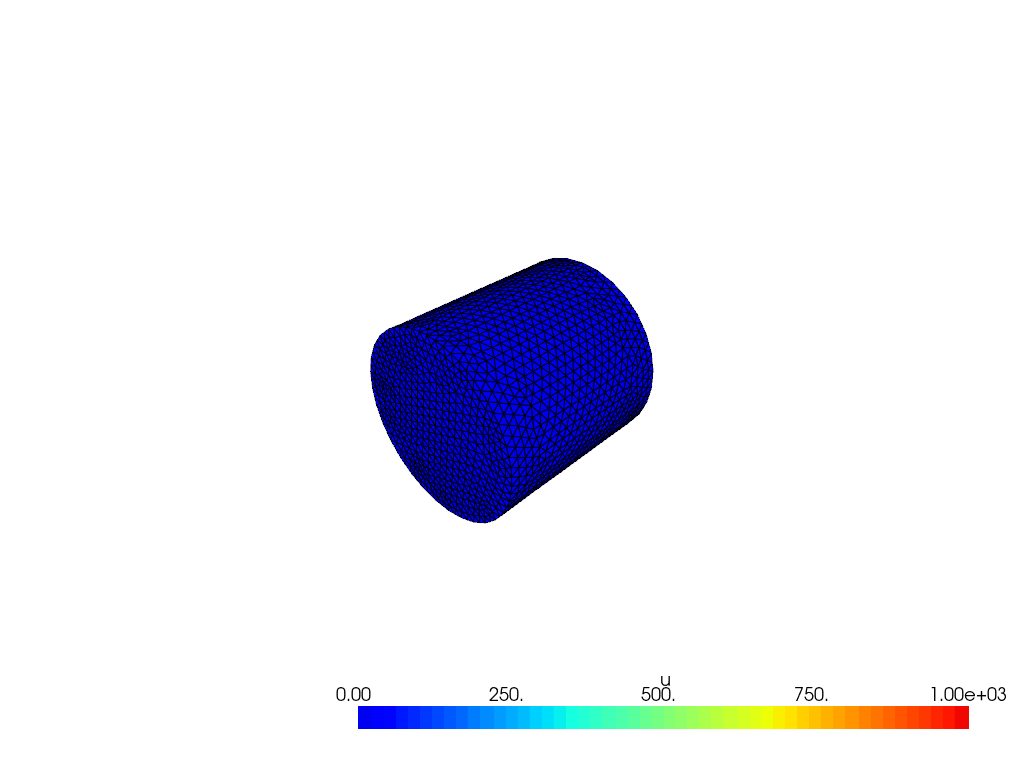

In [24]:
from IPython.display import Image
display(Image(data=open("results/3D_torsion_fixed_end.gif",'rb').read(), format='png'))

In [25]:
pyvista.set_jupyter_backend('client')
plotter = pyvista.Plotter()

V = fem.VectorFunctionSpace(domain,("Lagrange",2))
u_n = fem.Function(V)
u_ex = Expression(w.sub(0),V.element.interpolation_points())
u_n.interpolate(u_ex)

topology, cells, geometry = plot.vtk_mesh(V)

function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
values = np.zeros((geometry.shape[0], 3))
values[:, :len(u_n)] = u_n.x.array.reshape(geometry.shape[0], len(u_n))

function_grid["u"] = values
function_grid.set_active_vectors("u")

warped = function_grid.warp_by_vector("u", factor=1)
warped.set_active_vectors("u")

# Add mesh to plotter and visualize
warped["mag"] = magnitude.x.array
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 1000], scalars="mag")


# Compute magnitude of displacement to visualize in GIF 
Vs = FunctionSpace(domain,("Lagrange", 2))
magnitude = fem.Function(Vs)
us = fem.Expression(u_n[1], Vs.element.interpolation_points())
magnitude.interpolate(Mises_Vis)

#print(u_n.function_space.dofmap.list)

#plotter.add_mesh_clip_plane(warped)

plotter.render()
plotter.show()


  V = fem.VectorFunctionSpace(domain,("Lagrange",2))



Widget(value="<iframe src='http://localhost:49533/index.html?ui=P_0x2a29b5ed0_0&reconnect=auto' style='width: …

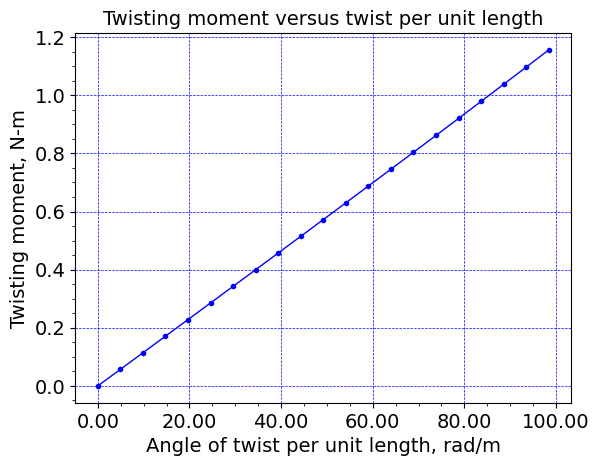

<Figure size 700x500 with 0 Axes>

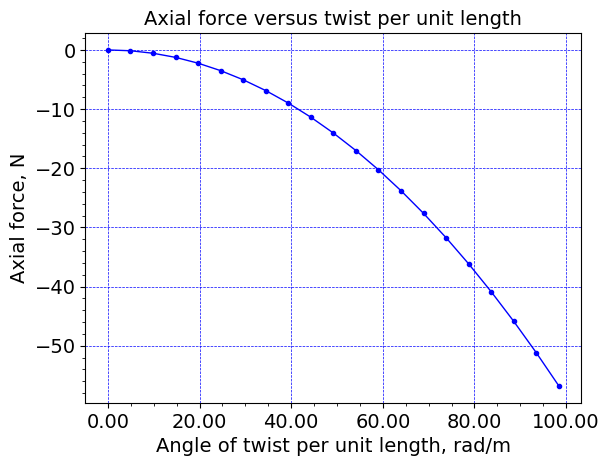

<Figure size 700x500 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
# set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#  Torque versus twist curve:  
#
fig = plt.figure() 
#fig.set_size_inches(7,4)
ax=fig.gca()  
plt.plot(Torq[:,0]/25.4E-3, Torq[:,1]/1.E6 , c='b', linewidth=1.0, marker='.')
#-------------------------------------------------------------
#ax.set.xlim(-0.01,0.01)
#ax.set.ylim(-0.03,0.03)
#plt.axis('tight')
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax.set_xlabel("Angle of twist per unit length, rad/m",size=14)
ax.set_ylabel("Twisting moment, N-m",size=14)
ax.set_title("Twisting moment versus twist per unit length", size=14, weight='normal')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()   

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/3D_torsion_torque_twist.png", dpi=600)

    
#  Normal force versus twist curve:  
#
fig = plt.figure() 
#fig.set_size_inches(7,4)
ax=fig.gca()  
plt.plot(Forc[:,0]/25.4E-3, Forc[:,1]/1.E3, c='b', linewidth=1.0, marker='.')
#-------------------------------------------------------------
#ax.set.xlim(-0.01,0.01)
#ax.set.ylim(-0.03,0.03)
#plt.axis('tight')
plt.grid(linestyle="--", linewidth=0.5, color='b')
ax.set_xlabel("Angle of twist per unit length, rad/m",size=14)
ax.set_ylabel("Axial force, N",size=14)
ax.set_title("Axial force versus twist per unit length", size=14, weight='normal')
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()   

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/3D_torsion_axial_force_twist.png", dpi=600)
